In [75]:
%matplotlib inline
import pandas as pd
import seaborn as sns

In [76]:
import pylab
sns.set(font_scale=2)
pylab.rcParams['figure.figsize'] = (24, 18)

In [290]:
def xirr(transactions):
    years = [(ta[0] - transactions[0][0]).days / 365.0 for ta in transactions]
    residual = 1
    step = 0.05
    guess = 0.08
    epsilon = 0.0001
    limit = 10000
    while abs(residual) > epsilon and limit > 0:
        limit -= 1
        residual = 0.0
        for i, ta in enumerate(transactions):
            residual += ta[1] / pow(guess, years[i])
        if abs(residual) > epsilon:
            if residual > 0:
                guess += step
            else:
                guess -= step
                step /= 2.0
    return guess-1

In [227]:
x=pd.read_csv('IRR_data.csv',index_col=3,parse_dates=['Transaction Date'])
sp=pd.read_csv('SP500.csv',parse_dates=['DATE'],index_col=0,na_values='.')

In [249]:
df=pd.read_csv('IRR_data.csv',parse_dates=['Transaction Date'],na_values='.')
df=pd.pivot_table(df,columns='Security Description',index='Transaction Date')
df['SP']=sp.SP500


# Calculate IRR 

1.3458920183518959

0.0410958904109589

In [291]:
funds={}
funds_wo_fee={}
sp_rtn=pd.Series()
year=pd.Series()
for r in x.iterrows():
    if r[0] not in funds.keys():
        funds[r[0]]=[]
        funds_wo_fee[r[0]]=[]
        year[r[0]]=r[1]['Transaction Date'].date().year
        ann_years=(dt.datetime.today().date()-r[1]['Transaction Date'].date()).days/365.
        sp_rtn[r[0]]=(sp.ix[-1].SP500/df.SP.ffill()[r[1]['Transaction Date']])**(1/ann_years)-1
    try:
        funds[r[0]].append([r[1]['Transaction Date'].date(),float(r[1]['Reporting Amount'])])
        if r[1]['Type']!='Fees paid - Asset account':
            funds_wo_fee[r[0]].append([r[1]['Transaction Date'].date(),float(r[1]['Reporting Amount'])])
    except:
        continue
    

In [292]:
rtn=pd.Series()
rtn_wo=pd.Series()
results=pd.DataFrame()
for f in funds.keys():
    val=round(xirr(funds[f])*100.,2)
    val_wo=round(xirr(funds_wo_fee[f])*100.,2) 
    if val>100:
        continue
    rtn[f]=val
    rtn_wo[f]=val_wo
results['IRR']=rtn
results['IRR without fees']=rtn_wo
results['Vintage']=year
results['SP Annualized Return since Inception']=(sp_rtn*100.).round(2)
results=results.sort_values('IRR')

In [293]:
results

,IRR,IRR without fees,Vintage,SP Annualized Return since Inception
Coachman Energy VII Offshore Feeder Bn,-34.53,-34.07,2015,9.47
HH Pre-IPO Offshr Feeder Fd II LP S B Bn,-10.12,-2.82,2017,14.21
Eur Special Sits Offshr Feeder Fd LP Bn,-3.15,-0.89,2016,17.47
European Primary Lending Opp Offshore Bn,1.91,2.54,2014,9.25
"W ST DF Onshore Feeder Fund, L.P. B",2.68,5.50,2016,15.09
C VIII Real Estate Opp Onshore A,3.06,4.83,2017,14.88
G Rockies Offshore Feeder Fund Ltd Bn,3.94,4.90,2015,12.47
"BTO II Offshore Feeder Fund, Ltd. Bn",4.72,7.38,2015,14.17
"CTP Offshore Feeder Fund, L.P. Bn",5.63,6.56,2014,9.77
Wellington HH Pr-IPO Ofshr Feeder Fd Bn,6.45,7.54,2015,9.50


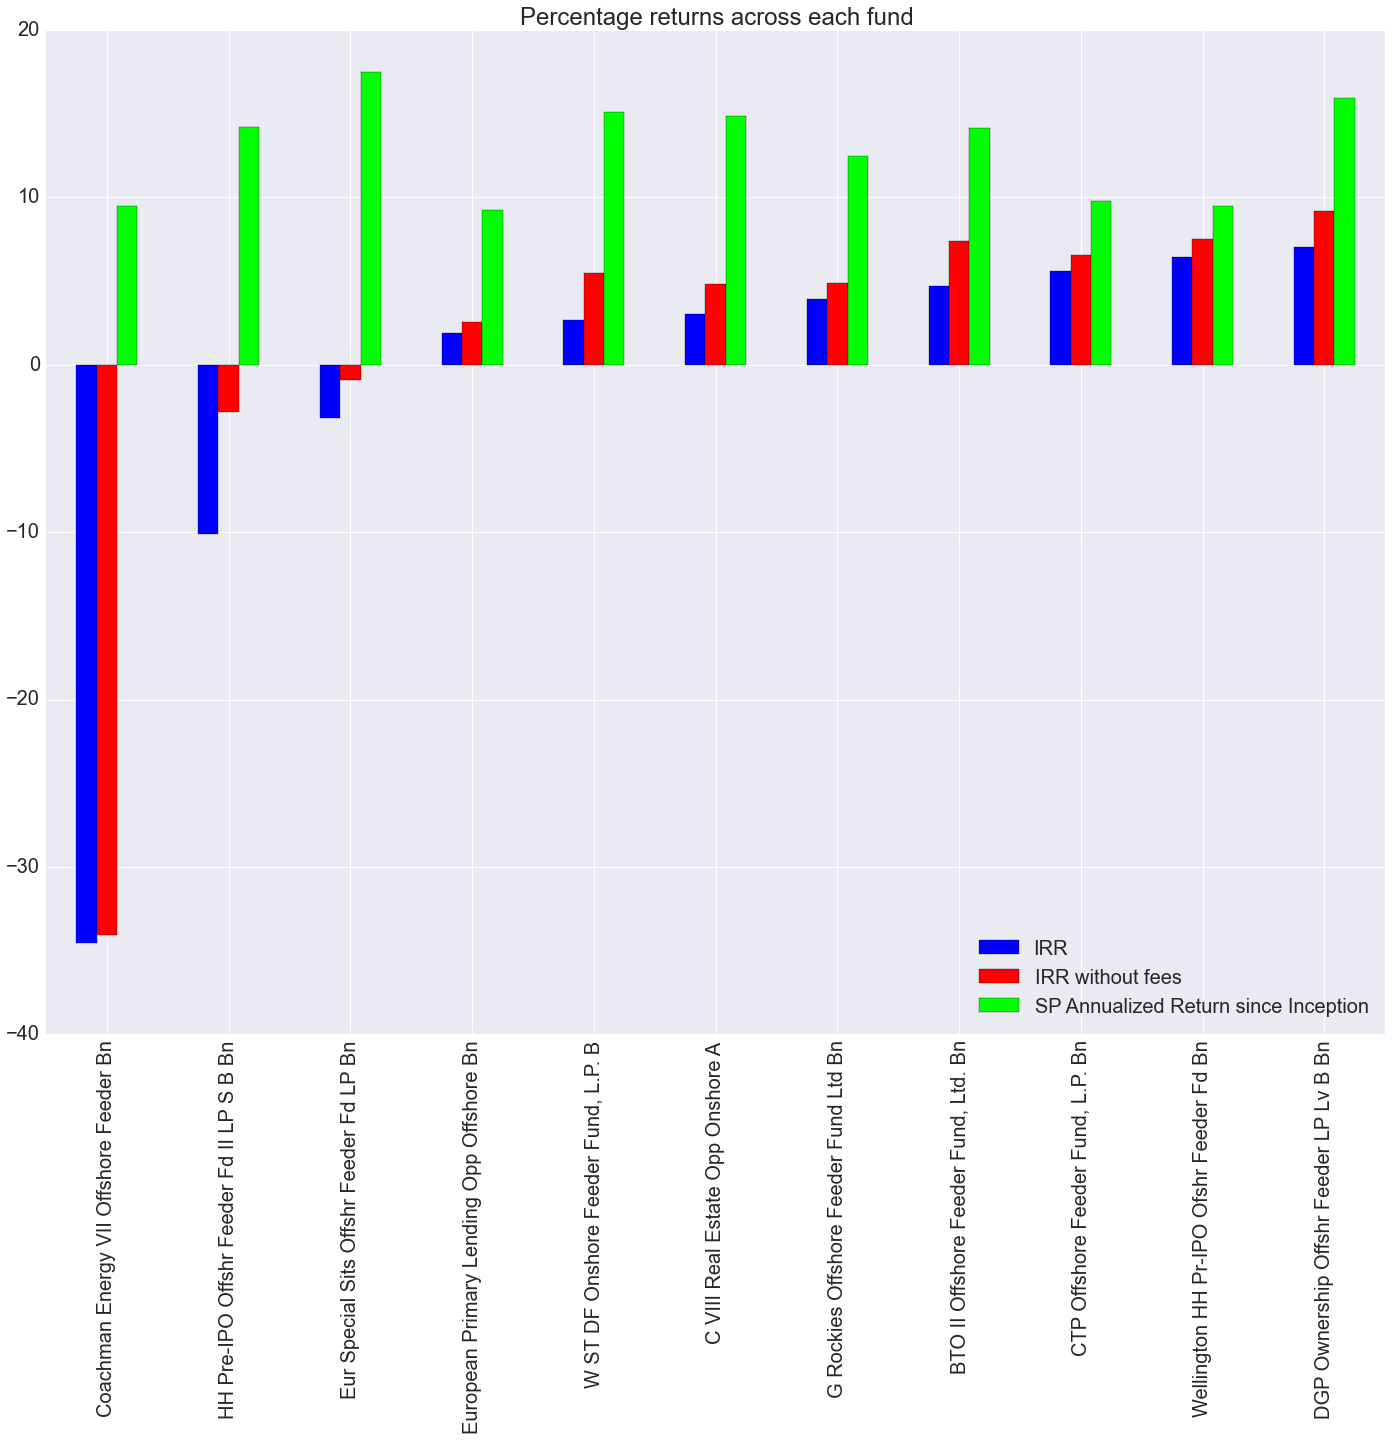

In [294]:
results[['IRR','IRR without fees','SP Annualized Return since Inception']].plot(kind='bar',colormap='brg', title='Percentage returns across each fund')

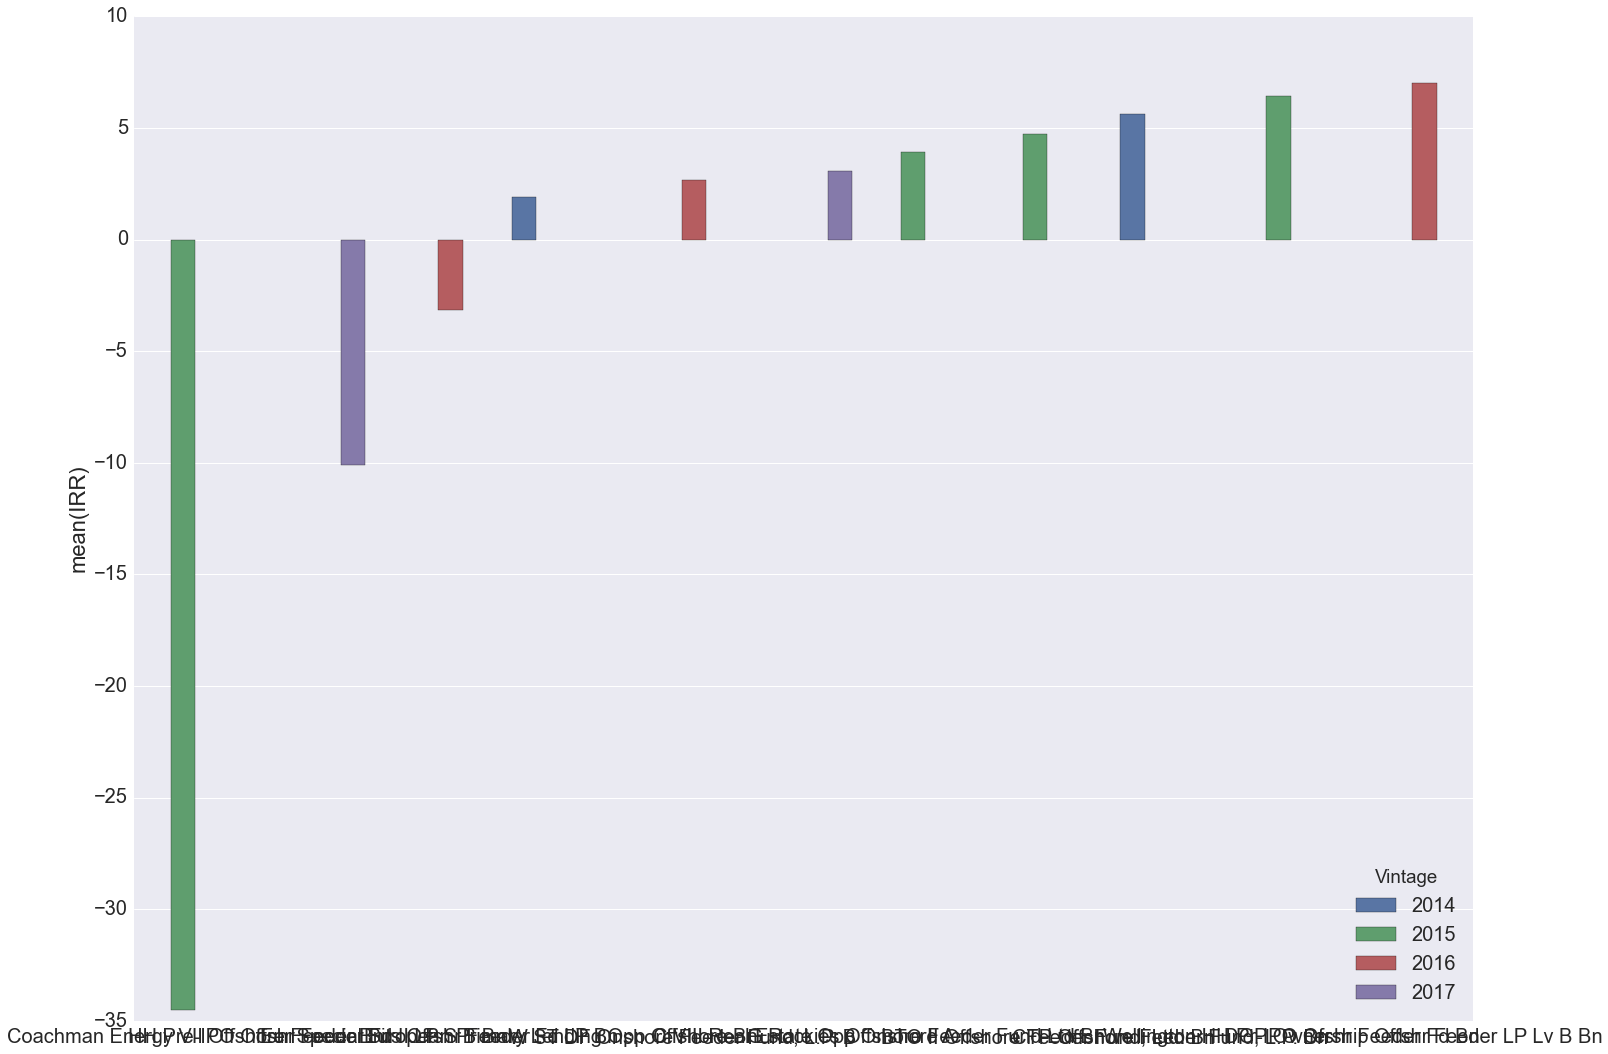

In [282]:
sns.barplot(results.index,results.IRR,hue=results.Vintage,orient=0)

# Time series of Capital

/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  """Entry point for launching an IPython kernel.


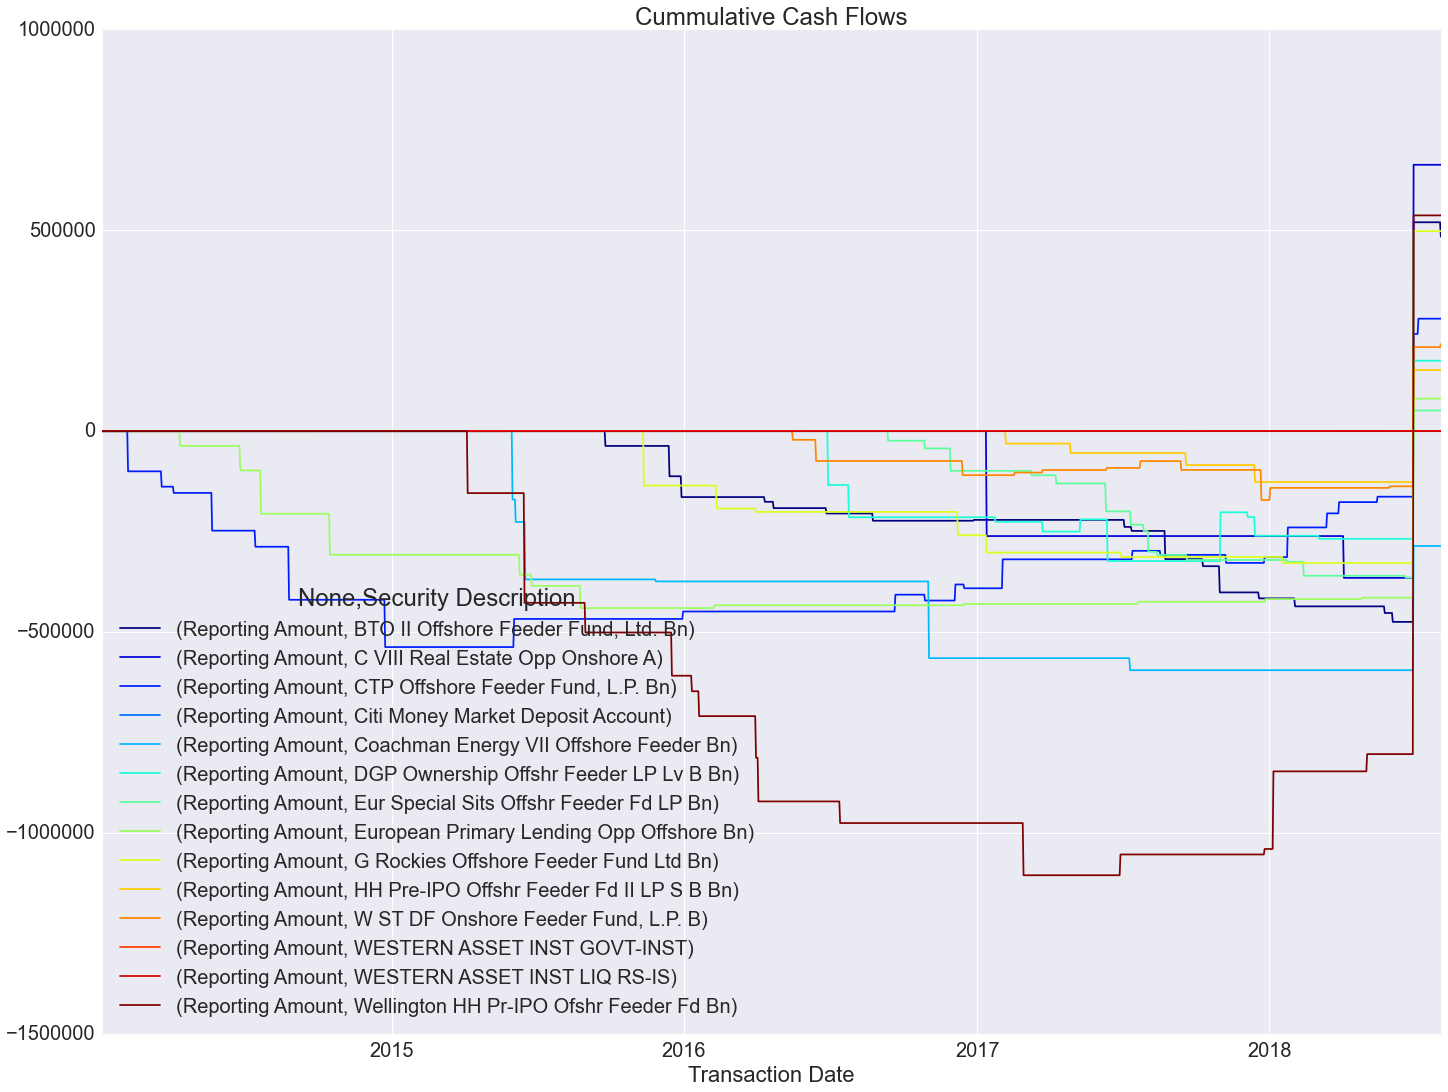

In [113]:
df.resample(rule='d',how='sum').cumsum().plot(colormap='jet',title='Cummulative Cash Flows')

# Return Multiples 

In [335]:
flows={}
for f in funds.keys():
    inflow=0
    outflow=0
    for r in funds[f]:
        if r[1]>0:
            inflow=inflow+r[1]
        else:
            outflow=outflow+r[1]
    flows[f]=[inflow,outflow*-1.]

In [336]:
a=pd.DataFrame(flows,index=['Inflow','Outflow']).T

/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


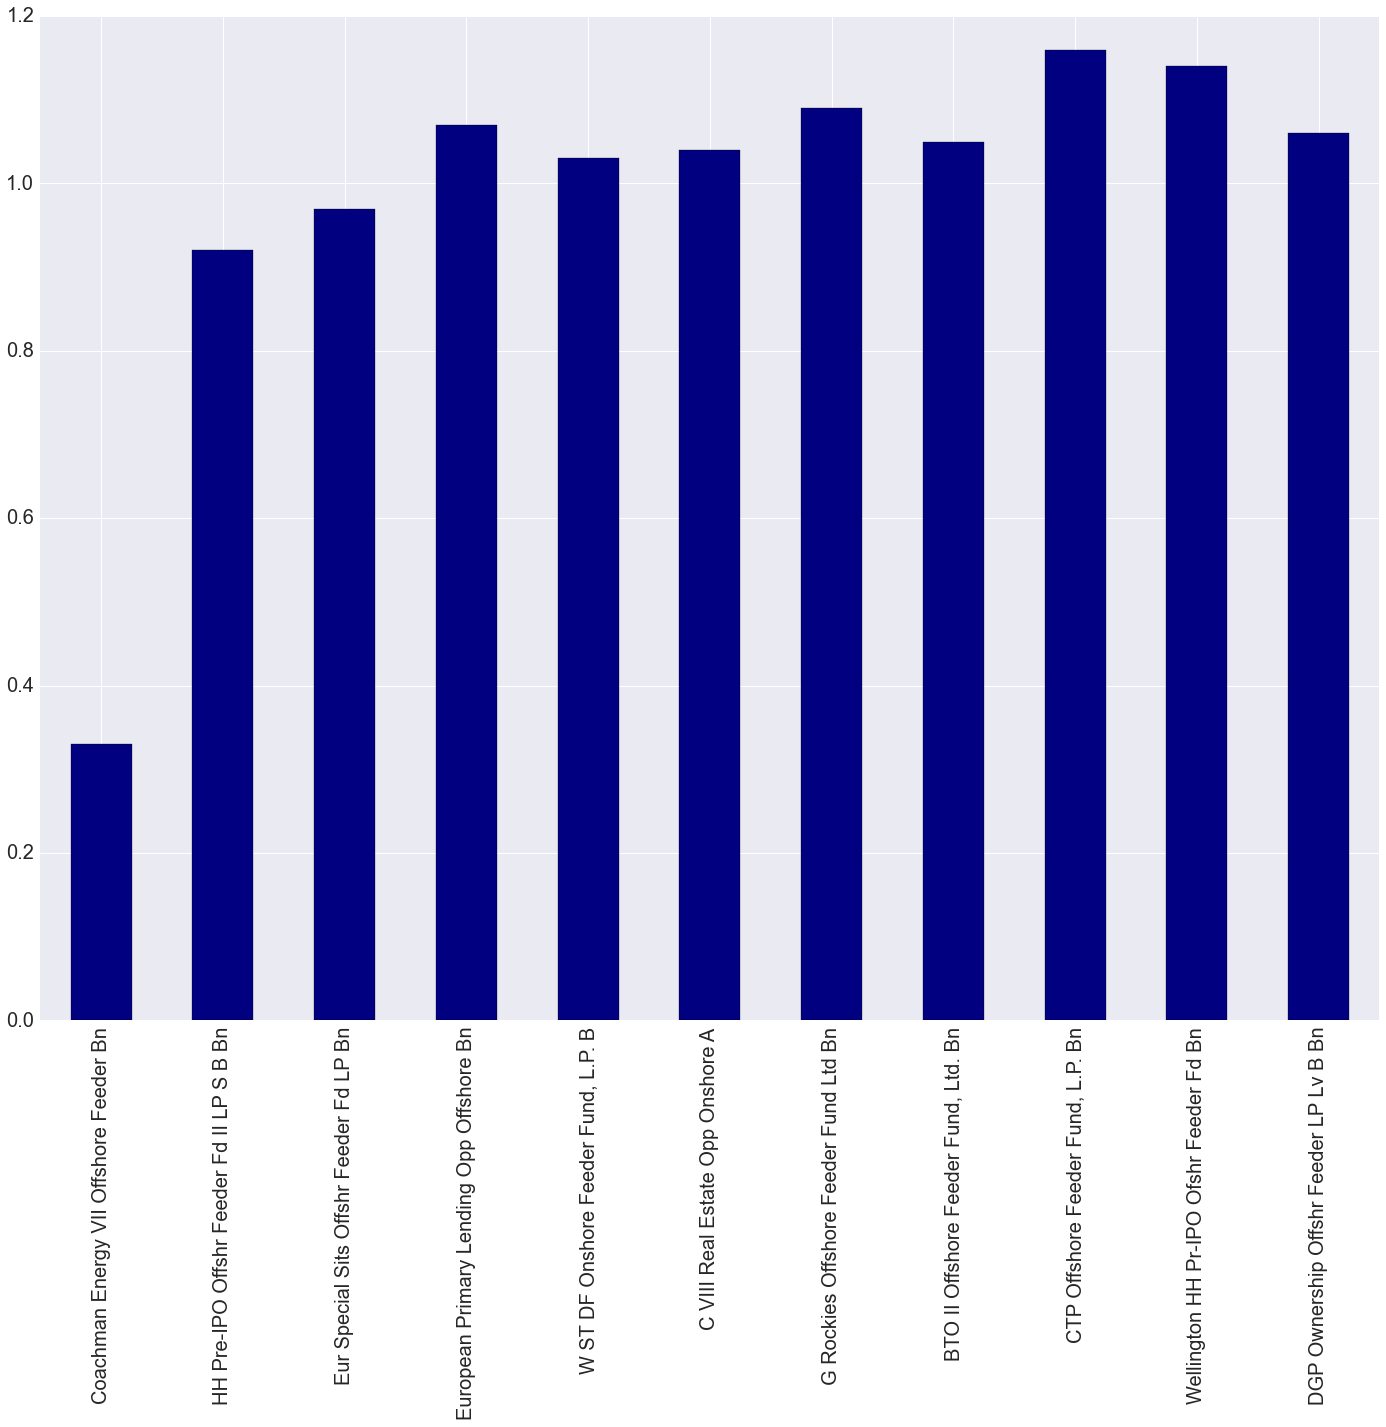

In [346]:
(a.Inflow/a.Outflow).round(2).ix[results.index].plot(kind='bar',colormap='jet')

In [353]:
final_res=results[[u'IRR', u'IRR without fees',
       u'SP Annualized Return since Inception']]
final_res['Multiples']=(a.Inflow/a.Outflow).round(2).ix[results.index]

/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until


array([<matplotlib.axes._subplots.AxesSubplot object at 0x112256410>], dtype=object)

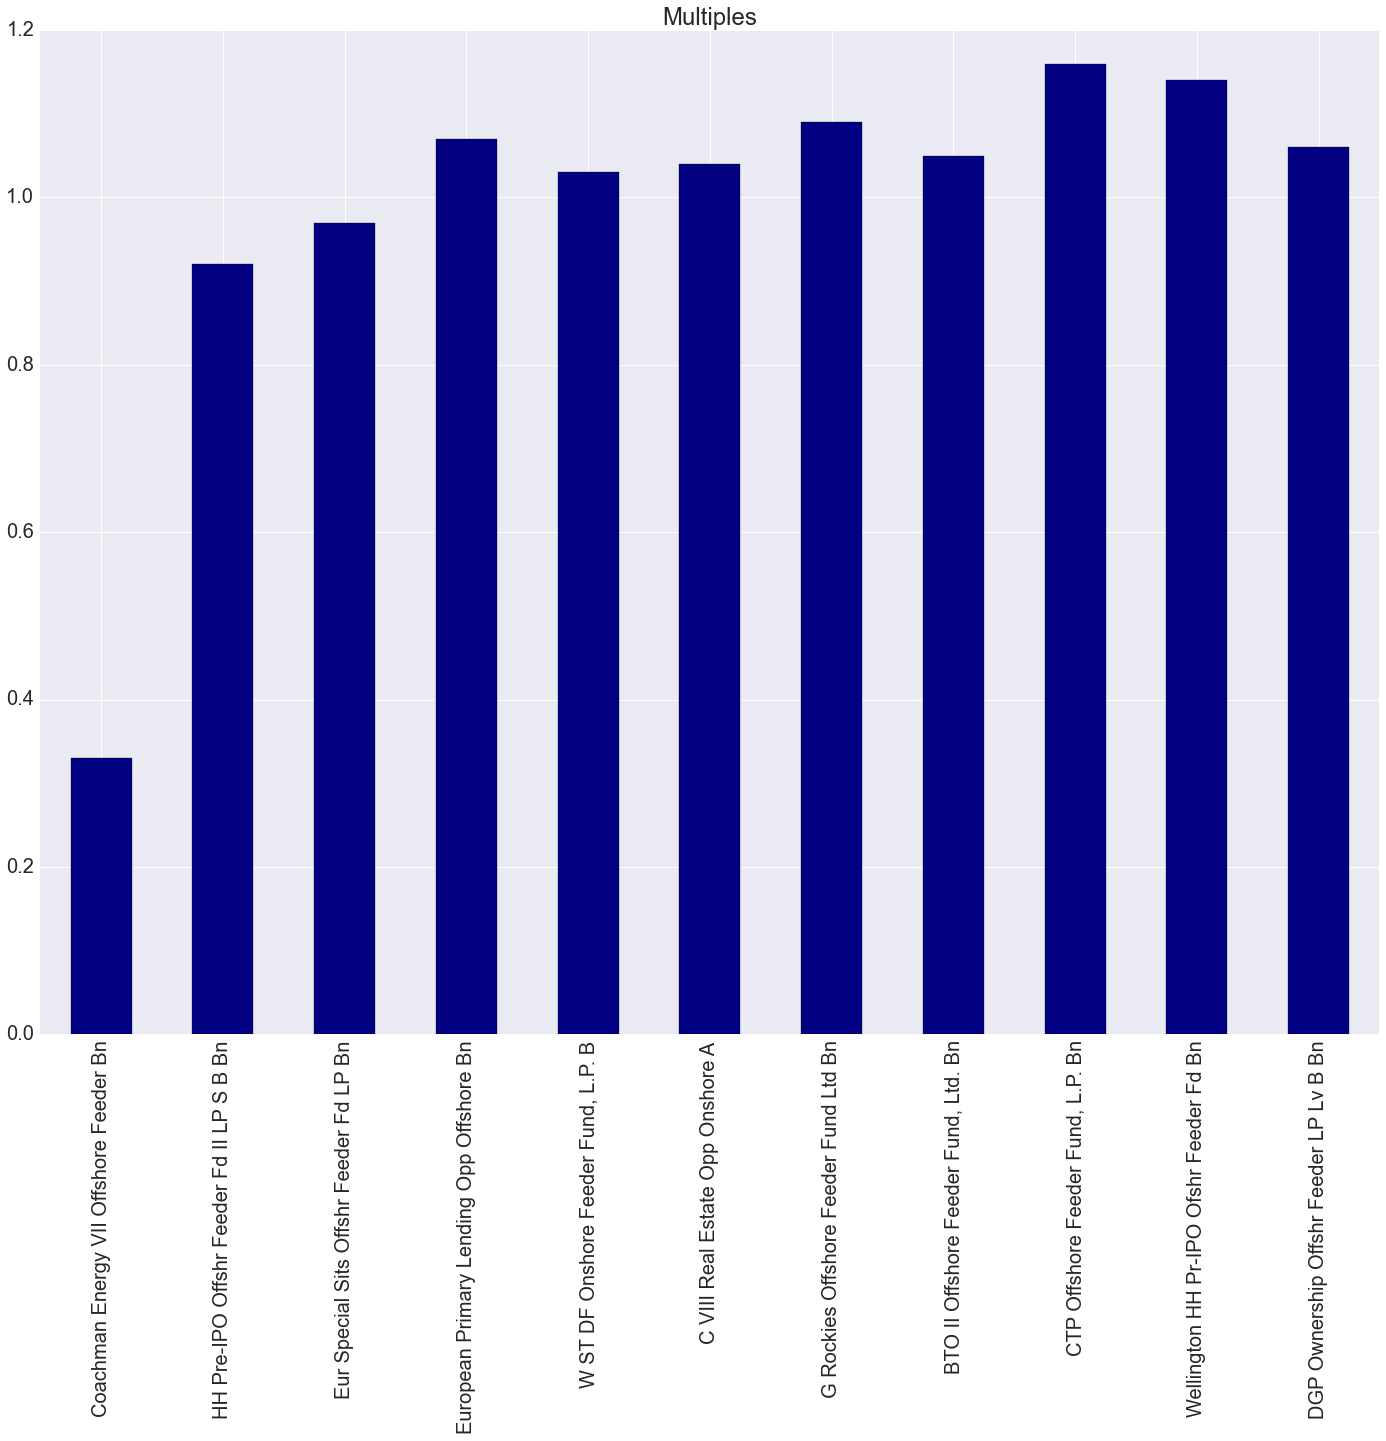

In [370]:
final_res.Multiples.plot(kind='bar',subplots=True,colormap='jet')